In [1]:
# Cell 1: Import required libraries
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from transformers import RTDetrImageProcessor, RTDetrForObjectDetection
import os

DATASET_PATH = "E:\\Python\\DLCV\\Project\\dataset\\coco"

MODEL = "E:\\Python\\DLCV\\Project\\outputs\\epoch-12_0.1dataset"
# MODEL = "PekingU/rtdetr_r18vd"


CONFIDENCE_THRESHOLD = 0.3

print(f"Dataset path: {DATASET_PATH}")
print(f"Model path: {MODEL}")
print(f"Confidence threshold: {CONFIDENCE_THRESHOLD}")

Dataset path: E:\Python\DLCV\Project\dataset\coco
Model path: E:\Python\DLCV\Project\outputs\epoch-12_0.1dataset
Confidence threshold: 0.3


In [2]:
# Cell 2: Load model and processor

processor = RTDetrImageProcessor.from_pretrained(MODEL)
model = RTDetrForObjectDetection.from_pretrained(MODEL)

# Set device and move model
# device = 'cpu'
device = 'cuda'
model.to(device)
model.eval()

print(f"Model loaded on device: {device}")

class_names = [
    'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck',
    'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench',
    'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra',
    'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
    'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
    'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange',
    'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
    'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse',
    'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink',
    'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

Model loaded on device: cuda


In [3]:
# Cell 4: Import additional libraries for validation
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import json
from tqdm import tqdm
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

val_annotations_file = os.path.join(DATASET_PATH, "annotations", "instances_val2017.json")
val_images_dir = os.path.join(DATASET_PATH, "val2017")

print(f"Loading annotations from: {val_annotations_file}")
print(f"Images directory: {val_images_dir}")

coco_gt = COCO(val_annotations_file)
image_ids = coco_gt.getImgIds()

print(f"Total validation images: {len(image_ids)}")

Loading annotations from: E:\Python\DLCV\Project\dataset\coco\annotations\instances_val2017.json
Images directory: E:\Python\DLCV\Project\dataset\coco\val2017
loading annotations into memory...
Done (t=0.37s)
creating index...
index created!
Total validation images: 5000


In [4]:
# Build mapping, generate mapped predictions, and run COCOeval
import json
from tqdm import tqdm
import numpy as np

# 1) Build mapping: COCO name -> COCO id
coco_cats = coco_gt.loadCats(coco_gt.getCatIds())
coco_name_to_id = {c['name']: c['id'] for c in coco_cats}
print("Loaded COCO categories:", len(coco_name_to_id))

# 2) Build label_index -> coco_category_id mapping based on your class_names list
label_to_coco_id = []
missing_names = []
for i, name in enumerate(class_names):
    coco_id = coco_name_to_id.get(name)
    label_to_coco_id.append(coco_id)
    if coco_id is None:
        missing_names.append((i, name))

print("Example mappings (first 20):")
for i in range(min(20, len(label_to_coco_id))):
    print(i, label_to_coco_id[i], class_names[i])

Loaded COCO categories: 80
Example mappings (first 20):
0 1 person
1 2 bicycle
2 3 car
3 4 motorcycle
4 5 airplane
5 6 bus
6 7 train
7 8 truck
8 9 boat
9 10 traffic light
10 11 fire hydrant
11 13 stop sign
12 14 parking meter
13 15 bench
14 16 bird
15 17 cat
16 18 dog
17 19 horse
18 20 sheep
19 21 cow


In [5]:
def run_inference(image_path, model, processor, device, threshold=0.3):
    """Run inference on a single image"""
    image = Image.open(image_path).convert("RGB")
    
    # Preprocess
    inputs = processor(images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Inference
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Post-process
    target_sizes = torch.tensor([image.size[::-1]]).to(device)
    results = processor.post_process_object_detection(
        outputs, 
        target_sizes=target_sizes, 
        threshold=threshold
    )[0]
    
    return results, image.size

In [6]:
# Cell: Generate COCO-mapped predictions and run evaluation
import json
import numpy as np
from tqdm import tqdm

# Adjust inference threshold (use low threshold so COCOeval can rank scores correctly)
INFER_THRESHOLD = 0.01  # keep low to preserve score distribution for AP calc

# 1) Build mapping: COCO name -> COCO id
coco_cats = coco_gt.loadCats(coco_gt.getCatIds())
coco_name_to_id = {c['name']: c['id'] for c in coco_cats}
print(f"Loaded {len(coco_name_to_id)} COCO categories")

# 2) Build label_index -> coco_category_id mapping based on your class_names list
label_to_coco_id = []
missing_names = []
for i, name in enumerate(class_names):
    coco_id = coco_name_to_id.get(name)
    label_to_coco_id.append(coco_id)
    if coco_id is None:
        missing_names.append((i, name))

# Print mapping diagnostics
print("\nExample mappings (first 20):")
for i in range(min(20, len(label_to_coco_id))):
    print(i, label_to_coco_id[i], class_names[i])

if missing_names:
    print(f"\nWarning: {len(missing_names)} class_names not found in COCO categories. Examples:")
    for idx, nm in missing_names[:20]:
        print(idx, nm)
    print("These labels will be skipped when creating mapped predictions. Fix class_names if necessary.")

# 3) Run inference over val images and create mapped predictions
predictions_mapped = []
skipped_count = 0
total_preds = 0

print("\nRunning inference and mapping labels to COCO ids...")
for img_id in tqdm(image_ids, desc="Images"):
    img_info = coco_gt.loadImgs(img_id)[0]
    img_path = os.path.join(val_images_dir, img_info['file_name'])
    if not os.path.exists(img_path):
        continue

    results, _ = run_inference(img_path, model, processor, device, threshold=INFER_THRESHOLD)
    boxes = results['boxes'].cpu().numpy()
    scores = results['scores'].cpu().numpy()
    labels = results['labels'].cpu().numpy()

    for box, score, label in zip(boxes, scores, labels):
        total_preds += 1
        lab = int(label)
        if lab < 0 or lab >= len(label_to_coco_id):
            skipped_count += 1
            continue
        coco_cat_id = label_to_coco_id[lab]
        if coco_cat_id is None:
            skipped_count += 1
            continue

        x_min, y_min, x_max, y_max = box.tolist()
        width = float(x_max - x_min)
        height = float(y_max - y_min)

        predictions_mapped.append({
            "image_id": int(img_id),
            "category_id": int(coco_cat_id),
            "bbox": [float(x_min), float(y_min), width, height],
            "score": float(score)
        })

print(f"\nTotal raw preds seen: {total_preds}")
print(f"Predictions mapped: {len(predictions_mapped)}")
print(f"Predictions skipped (no mapping / out of range): {skipped_count}")

Loaded 80 COCO categories

Example mappings (first 20):
0 1 person
1 2 bicycle
2 3 car
3 4 motorcycle
4 5 airplane
5 6 bus
6 7 train
7 8 truck
8 9 boat
9 10 traffic light
10 11 fire hydrant
11 13 stop sign
12 14 parking meter
13 15 bench
14 16 bird
15 17 cat
16 18 dog
17 19 horse
18 20 sheep
19 21 cow

Running inference and mapping labels to COCO ids...


Images: 100%|██████████| 5000/5000 [02:57<00:00, 28.14it/s]


Total raw preds seen: 1115525
Predictions mapped: 1115525
Predictions skipped (no mapping / out of range): 0


In [7]:
predictions_file_mapped = "predictions_mapped.json"
with open(predictions_file_mapped, "w") as f:
    json.dump(predictions_mapped, f)
print(f"Saved mapped predictions to {predictions_file_mapped}")

# Run COCO evaluation on mapped file
coco_dt = coco_gt.loadRes(predictions_file_mapped)
coco_eval = COCOeval(coco_gt, coco_dt, "bbox")
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

# Extract mAP metrics
print("\n" + "="*50)
print("COCO Evaluation Metrics:")
print("="*50)
print(f"mAP @ IoU=0.50:0.95: {coco_eval.stats[0]:.4f}")
print(f"mAP @ IoU=0.50:      {coco_eval.stats[1]:.4f}")
print(f"mAP @ IoU=0.75:      {coco_eval.stats[2]:.4f}")
print(f"mAP (small):         {coco_eval.stats[3]:.4f}")
print(f"mAP (medium):        {coco_eval.stats[4]:.4f}")
print(f"mAP (large):         {coco_eval.stats[5]:.4f}")


Saved mapped predictions to predictions_mapped.json
Loading and preparing results...
DONE (t=4.10s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=27.24s).
Accumulating evaluation results...
DONE (t=8.21s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.237
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.308
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.257
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.065
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.255
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.426
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.243
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.379
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.447
 Average Recall

In [8]:
# Cell 10: Calculate Precision-Recall curve per class
def calculate_pr_curve_per_class(coco_gt, coco_dt, iou_threshold=0.5):
    """Calculate precision-recall curve for each class"""
    pr_curves = {}
    
    category_ids = coco_gt.getCatIds()
    
    for cat_id in tqdm(category_ids, desc="Calculating PR curves"):
        # Get annotations for this category
        ann_ids = coco_gt.getAnnIds(catIds=[cat_id])
        if len(ann_ids) == 0:
            continue
        
        # Evaluate for this specific category
        coco_eval_cat = COCOeval(coco_gt, coco_dt, 'bbox')
        coco_eval_cat.params.catIds = [cat_id]
        coco_eval_cat.params.iouThrs = [iou_threshold]
        coco_eval_cat.evaluate()
        coco_eval_cat.accumulate()
        
        # precision shape: [TxRxKxAxM]
        precision_all = coco_eval_cat.eval.get('precision', None)
        if precision_all is None:
            # no precision data (no detections or unexpected), skip
            continue

        # K (category axis) is length 1 because params.catIds == [cat_id], so its index is 0
        k_idx = 0
        # area index: 0 corresponds to 'all' areas in default COCO (you can adapt if needed)
        area_idx = 0
        # use the last maxDet index (usually corresponds to max detections used in evaluation)
        maxdet_idx = -1

        try:
            precision = precision_all[0, :, k_idx, area_idx, maxdet_idx]  # T=0 because single IoU
        except Exception:
            # defensive fallback — try to squeeze and recover precision vector
            precision = np.squeeze(precision_all)
            # after squeezing it may have different dims; try to reduce to 1-d precision vector
            if precision.ndim > 1:
                # try to index category axis 0, area 0, last maxDet
                precision = precision[:, 0, -1] if precision.shape[1] > 0 else None

        if precision is None:
            continue

        recall = coco_eval_cat.params.recThrs  # array of recall thresholds
        # Filter out invalid entries marked as -1
        valid_idx = precision > -1
        if not np.any(valid_idx):
            continue

        precision = precision[valid_idx]
        recall = np.array(recall)[valid_idx]

        if len(precision) == 0:
            continue

        pr_curves[cat_id] = {
            'precision': precision,
            'recall': recall,
            # Use mean precision over the reported recall points as a simple per-class AP estimate at this IoU
            'ap': float(np.mean(precision))
        }
    
    return pr_curves

print("\nCalculating PR curves for each class...")
pr_curves = calculate_pr_curve_per_class(coco_gt, coco_dt, iou_threshold=0.5)




Calculating PR curves for each class...


Calculating PR curves:   0%|          | 0/80 [00:00<?, ?it/s]

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.18s).
Accumulating evaluation results...


Calculating PR curves:   1%|▏         | 1/80 [00:01<01:53,  1.43s/it]

DONE (t=0.24s).
Running per image evaluation...
Evaluate annotation type *bbox*


Calculating PR curves:   2%|▎         | 2/80 [00:01<01:01,  1.26it/s]

DONE (t=0.26s).
Accumulating evaluation results...
DONE (t=0.05s).
Running per image evaluation...
Evaluate annotation type *bbox*


Calculating PR curves:   4%|▍         | 3/80 [00:02<00:51,  1.49it/s]

DONE (t=0.44s).
Accumulating evaluation results...
DONE (t=0.09s).
Running per image evaluation...
Evaluate annotation type *bbox*


Calculating PR curves:   5%|▌         | 4/80 [00:02<00:39,  1.93it/s]

DONE (t=0.23s).
Accumulating evaluation results...
DONE (t=0.03s).
Running per image evaluation...
Evaluate annotation type *bbox*


Calculating PR curves:   6%|▋         | 5/80 [00:02<00:32,  2.28it/s]

DONE (t=0.25s).
Accumulating evaluation results...
DONE (t=0.04s).
Running per image evaluation...
Evaluate annotation type *bbox*


Calculating PR curves:   8%|▊         | 6/80 [00:03<00:29,  2.54it/s]

DONE (t=0.26s).
Accumulating evaluation results...
DONE (t=0.05s).
Running per image evaluation...
Evaluate annotation type *bbox*


Calculating PR curves:   9%|▉         | 7/80 [00:03<00:26,  2.75it/s]

DONE (t=0.25s).
Accumulating evaluation results...
DONE (t=0.04s).
Running per image evaluation...
Evaluate annotation type *bbox*


Calculating PR curves:  10%|█         | 8/80 [00:05<00:53,  1.35it/s]

DONE (t=1.49s).
Accumulating evaluation results...
DONE (t=0.05s).
Running per image evaluation...
Evaluate annotation type *bbox*


Calculating PR curves:  11%|█▏        | 9/80 [00:05<00:45,  1.57it/s]

DONE (t=0.33s).
Accumulating evaluation results...
DONE (t=0.06s).
Running per image evaluation...
Evaluate annotation type *bbox*


Calculating PR curves:  12%|█▎        | 10/80 [00:05<00:37,  1.87it/s]

DONE (t=0.24s).
Accumulating evaluation results...
DONE (t=0.05s).
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.21s).
Accumulating evaluation results...


Calculating PR curves:  14%|█▍        | 11/80 [00:05<00:30,  2.25it/s]

DONE (t=0.03s).
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.16s).
Accumulating evaluation results...
DONE (t=0.02s).


Calculating PR curves:  16%|█▋        | 13/80 [00:06<00:20,  3.23it/s]

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.15s).
Accumulating evaluation results...
DONE (t=0.02s).
Running per image evaluation...
Evaluate annotation type *bbox*


Calculating PR curves:  18%|█▊        | 14/80 [00:06<00:25,  2.58it/s]

DONE (t=0.46s).
Accumulating evaluation results...
DONE (t=0.11s).
Running per image evaluation...
Evaluate annotation type *bbox*


Calculating PR curves:  19%|█▉        | 15/80 [00:07<00:27,  2.38it/s]

DONE (t=0.39s).
Accumulating evaluation results...
DONE (t=0.08s).
Running per image evaluation...
Evaluate annotation type *bbox*


Calculating PR curves:  20%|██        | 16/80 [00:07<00:25,  2.52it/s]

DONE (t=0.28s).
Accumulating evaluation results...
DONE (t=0.05s).
Running per image evaluation...
Evaluate annotation type *bbox*


Calculating PR curves:  21%|██▏       | 17/80 [00:08<00:23,  2.66it/s]

DONE (t=0.27s).
Accumulating evaluation results...
DONE (t=0.05s).
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.23s).
Accumulating evaluation results...


Calculating PR curves:  22%|██▎       | 18/80 [00:08<00:21,  2.87it/s]

DONE (t=0.04s).
Running per image evaluation...
Evaluate annotation type *bbox*


Calculating PR curves:  24%|██▍       | 19/80 [00:08<00:20,  3.02it/s]

DONE (t=0.25s).
Accumulating evaluation results...
DONE (t=0.04s).
Running per image evaluation...
Evaluate annotation type *bbox*


Calculating PR curves:  25%|██▌       | 20/80 [00:09<00:19,  3.02it/s]

DONE (t=0.28s).
Accumulating evaluation results...
DONE (t=0.05s).
Running per image evaluation...
Evaluate annotation type *bbox*


Calculating PR curves:  26%|██▋       | 21/80 [00:09<00:19,  3.05it/s]

DONE (t=0.27s).
Accumulating evaluation results...
DONE (t=0.05s).
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.17s).
Accumulating evaluation results...


Calculating PR curves:  28%|██▊       | 22/80 [00:09<00:16,  3.45it/s]

DONE (t=0.02s).
Running per image evaluation...
Evaluate annotation type *bbox*


Calculating PR curves:  29%|██▉       | 23/80 [00:09<00:16,  3.46it/s]

DONE (t=0.24s).
Accumulating evaluation results...
DONE (t=0.04s).
Running per image evaluation...
Evaluate annotation type *bbox*


Calculating PR curves:  30%|███       | 24/80 [00:10<00:16,  3.48it/s]

DONE (t=0.23s).
Accumulating evaluation results...
DONE (t=0.04s).
Running per image evaluation...
Evaluate annotation type *bbox*


Calculating PR curves:  31%|███▏      | 25/80 [00:10<00:17,  3.17it/s]

DONE (t=0.31s).
Accumulating evaluation results...
DONE (t=0.06s).
Running per image evaluation...
Evaluate annotation type *bbox*


Calculating PR curves:  32%|███▎      | 26/80 [00:10<00:19,  2.73it/s]

DONE (t=0.39s).
Accumulating evaluation results...
DONE (t=0.08s).
Running per image evaluation...
Evaluate annotation type *bbox*


Calculating PR curves:  34%|███▍      | 27/80 [00:11<00:20,  2.65it/s]

DONE (t=0.32s).
Accumulating evaluation results...
DONE (t=0.06s).
Running per image evaluation...
Evaluate annotation type *bbox*


Calculating PR curves:  35%|███▌      | 28/80 [00:11<00:19,  2.69it/s]

DONE (t=0.29s).
Accumulating evaluation results...
DONE (t=0.06s).
Running per image evaluation...
Evaluate annotation type *bbox*


Calculating PR curves:  36%|███▋      | 29/80 [00:12<00:18,  2.74it/s]

DONE (t=0.29s).
Accumulating evaluation results...
DONE (t=0.05s).
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.17s).
Accumulating evaluation results...


Calculating PR curves:  38%|███▊      | 30/80 [00:12<00:15,  3.16it/s]

DONE (t=0.02s).
Running per image evaluation...
Evaluate annotation type *bbox*


Calculating PR curves:  39%|███▉      | 31/80 [00:12<00:14,  3.28it/s]

DONE (t=0.24s).
Accumulating evaluation results...
DONE (t=0.04s).
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.19s).
Accumulating evaluation results...


Calculating PR curves:  40%|████      | 32/80 [00:12<00:13,  3.58it/s]

DONE (t=0.03s).
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.21s).
Accumulating evaluation results...


Calculating PR curves:  41%|████▏     | 33/80 [00:13<00:12,  3.71it/s]

DONE (t=0.03s).
Running per image evaluation...
Evaluate annotation type *bbox*


Calculating PR curves:  42%|████▎     | 34/80 [00:13<00:13,  3.43it/s]

DONE (t=0.29s).
Accumulating evaluation results...
DONE (t=0.05s).
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.20s).
Accumulating evaluation results...


Calculating PR curves:  44%|████▍     | 35/80 [00:13<00:12,  3.63it/s]

DONE (t=0.03s).
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.16s).
Accumulating evaluation results...
DONE (t=0.02s).


Calculating PR curves:  45%|████▌     | 36/80 [00:13<00:10,  4.03it/s]

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.18s).
Accumulating evaluation results...


Calculating PR curves:  46%|████▋     | 37/80 [00:14<00:10,  4.18it/s]

DONE (t=0.03s).
Running per image evaluation...
Evaluate annotation type *bbox*


Calculating PR curves:  48%|████▊     | 38/80 [00:14<00:10,  3.99it/s]

DONE (t=0.23s).
Accumulating evaluation results...
DONE (t=0.04s).
Running per image evaluation...
Evaluate annotation type *bbox*


Calculating PR curves:  49%|████▉     | 39/80 [00:14<00:10,  3.96it/s]

DONE (t=0.21s).
Accumulating evaluation results...
DONE (t=0.03s).
Running per image evaluation...
Evaluate annotation type *bbox*


Calculating PR curves:  50%|█████     | 40/80 [00:15<00:12,  3.16it/s]

DONE (t=0.38s).
Accumulating evaluation results...
DONE (t=0.08s).
Running per image evaluation...
Evaluate annotation type *bbox*


Calculating PR curves:  51%|█████▏    | 41/80 [00:15<00:11,  3.34it/s]

DONE (t=0.21s).
Accumulating evaluation results...
DONE (t=0.03s).
Running per image evaluation...
Evaluate annotation type *bbox*


Calculating PR curves:  52%|█████▎    | 42/80 [00:15<00:12,  3.02it/s]

DONE (t=0.34s).
Accumulating evaluation results...
DONE (t=0.06s).
Running per image evaluation...
Evaluate annotation type *bbox*


Calculating PR curves:  54%|█████▍    | 43/80 [00:15<00:11,  3.28it/s]

DONE (t=0.20s).
Accumulating evaluation results...
DONE (t=0.03s).
Running per image evaluation...
Evaluate annotation type *bbox*


Calculating PR curves:  55%|█████▌    | 44/80 [00:16<00:10,  3.40it/s]

DONE (t=0.22s).
Accumulating evaluation results...
DONE (t=0.04s).
Running per image evaluation...
Evaluate annotation type *bbox*


Calculating PR curves:  56%|█████▋    | 45/80 [00:16<00:09,  3.53it/s]

DONE (t=0.22s).
Accumulating evaluation results...
DONE (t=0.03s).
Running per image evaluation...
Evaluate annotation type *bbox*


Calculating PR curves:  57%|█████▊    | 46/80 [00:16<00:10,  3.36it/s]

DONE (t=0.27s).
Accumulating evaluation results...
DONE (t=0.05s).
Running per image evaluation...
Evaluate annotation type *bbox*


Calculating PR curves:  59%|█████▉    | 47/80 [00:17<00:11,  2.96it/s]

DONE (t=0.36s).
Accumulating evaluation results...
DONE (t=0.07s).
Running per image evaluation...
Evaluate annotation type *bbox*


Calculating PR curves:  60%|██████    | 48/80 [00:17<00:10,  3.08it/s]

DONE (t=0.24s).
Accumulating evaluation results...
DONE (t=0.04s).
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.19s).
Accumulating evaluation results...


Calculating PR curves:  61%|██████▏   | 49/80 [00:17<00:09,  3.40it/s]

DONE (t=0.03s).
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.21s).
Accumulating evaluation results...


Calculating PR curves:  62%|██████▎   | 50/80 [00:17<00:08,  3.56it/s]

DONE (t=0.03s).
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.21s).
Accumulating evaluation results...


Calculating PR curves:  64%|██████▍   | 51/80 [00:18<00:07,  3.69it/s]

DONE (t=0.03s).
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.22s).
Accumulating evaluation results...


Calculating PR curves:  65%|██████▌   | 52/80 [00:18<00:07,  3.73it/s]

DONE (t=0.03s).
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.16s).
Accumulating evaluation results...
DONE (t=0.02s).


Calculating PR curves:  66%|██████▋   | 53/80 [00:18<00:06,  4.07it/s]

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.19s).
Accumulating evaluation results...


Calculating PR curves:  68%|██████▊   | 54/80 [00:18<00:06,  4.15it/s]

DONE (t=0.03s).
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.17s).
Accumulating evaluation results...
DONE (t=0.02s).


Calculating PR curves:  69%|██████▉   | 55/80 [00:19<00:05,  4.38it/s]

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.22s).
Accumulating evaluation results...


Calculating PR curves:  70%|███████   | 56/80 [00:19<00:05,  4.16it/s]

DONE (t=0.04s).
Running per image evaluation...
Evaluate annotation type *bbox*


Calculating PR curves:  71%|███████▏  | 57/80 [00:20<00:09,  2.49it/s]

DONE (t=0.63s).
Accumulating evaluation results...
DONE (t=0.14s).
Running per image evaluation...
Evaluate annotation type *bbox*


Calculating PR curves:  72%|███████▎  | 58/80 [00:20<00:09,  2.42it/s]

DONE (t=0.34s).
Accumulating evaluation results...
DONE (t=0.07s).
Running per image evaluation...
Evaluate annotation type *bbox*


Calculating PR curves:  74%|███████▍  | 59/80 [00:20<00:08,  2.44it/s]

DONE (t=0.31s).
Accumulating evaluation results...
DONE (t=0.08s).
Running per image evaluation...
Evaluate annotation type *bbox*


Calculating PR curves:  75%|███████▌  | 60/80 [00:21<00:08,  2.29it/s]

DONE (t=0.40s).
Accumulating evaluation results...
DONE (t=0.09s).
Running per image evaluation...
Evaluate annotation type *bbox*


Calculating PR curves:  76%|███████▋  | 61/80 [00:23<00:15,  1.20it/s]

DONE (t=1.65s).
Accumulating evaluation results...
DONE (t=0.10s).
Running per image evaluation...
Evaluate annotation type *bbox*


Calculating PR curves:  78%|███████▊  | 62/80 [00:23<00:12,  1.49it/s]

DONE (t=0.24s).
Accumulating evaluation results...
DONE (t=0.04s).
Running per image evaluation...
Evaluate annotation type *bbox*


Calculating PR curves:  79%|███████▉  | 63/80 [00:23<00:09,  1.82it/s]

DONE (t=0.22s).
Accumulating evaluation results...
DONE (t=0.04s).
Running per image evaluation...
Evaluate annotation type *bbox*


Calculating PR curves:  80%|████████  | 64/80 [00:24<00:07,  2.12it/s]

DONE (t=0.24s).
Accumulating evaluation results...
DONE (t=0.04s).
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.15s).
Accumulating evaluation results...


Calculating PR curves:  81%|████████▏ | 65/80 [00:24<00:05,  2.61it/s]

DONE (t=0.02s).
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.18s).
Accumulating evaluation results...
DONE (t=0.02s).


Calculating PR curves:  82%|████████▎ | 66/80 [00:24<00:04,  3.03it/s]

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.20s).
Accumulating evaluation results...


Calculating PR curves:  84%|████████▍ | 67/80 [00:24<00:03,  3.30it/s]

DONE (t=0.03s).
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.22s).
Accumulating evaluation results...


Calculating PR curves:  85%|████████▌ | 68/80 [00:24<00:03,  3.41it/s]

DONE (t=0.04s).
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.18s).
Accumulating evaluation results...


Calculating PR curves:  86%|████████▋ | 69/80 [00:25<00:02,  3.72it/s]

DONE (t=0.02s).
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.24s).
Accumulating evaluation results...


Calculating PR curves:  89%|████████▉ | 71/80 [00:25<00:02,  4.34it/s]

DONE (t=0.04s).
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.11s).
Accumulating evaluation results...
DONE (t=0.01s).
Running per image evaluation...
Evaluate annotation type *bbox*


Calculating PR curves:  90%|█████████ | 72/80 [00:25<00:02,  3.92it/s]

DONE (t=0.26s).
Accumulating evaluation results...
DONE (t=0.05s).
Running per image evaluation...
Evaluate annotation type *bbox*


Calculating PR curves:  91%|█████████▏| 73/80 [00:26<00:01,  3.55it/s]

DONE (t=0.28s).
Accumulating evaluation results...
DONE (t=0.05s).
Running per image evaluation...
Evaluate annotation type *bbox*


Calculating PR curves:  92%|█████████▎| 74/80 [00:26<00:02,  2.78it/s]

DONE (t=0.44s).
Accumulating evaluation results...
DONE (t=0.09s).
Running per image evaluation...
Evaluate annotation type *bbox*


Calculating PR curves:  94%|█████████▍| 75/80 [00:27<00:01,  2.95it/s]

DONE (t=0.24s).
Accumulating evaluation results...
DONE (t=0.04s).
Running per image evaluation...
Evaluate annotation type *bbox*


Calculating PR curves:  95%|█████████▌| 76/80 [00:27<00:01,  3.23it/s]

DONE (t=0.20s).
Accumulating evaluation results...
DONE (t=0.03s).
Running per image evaluation...
Evaluate annotation type *bbox*


Calculating PR curves:  96%|█████████▋| 77/80 [00:27<00:00,  3.32it/s]

DONE (t=0.23s).
Accumulating evaluation results...
DONE (t=0.04s).
Running per image evaluation...
Evaluate annotation type *bbox*


Calculating PR curves:  98%|█████████▊| 78/80 [00:27<00:00,  3.30it/s]

DONE (t=0.26s).
Accumulating evaluation results...
DONE (t=0.04s).
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.13s).
Accumulating evaluation results...
DONE (t=0.01s).


Calculating PR curves: 100%|██████████| 80/80 [00:28<00:00,  4.17it/s]

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.17s).
Accumulating evaluation results...
DONE (t=0.02s).


Calculating PR curves: 100%|██████████| 80/80 [00:28<00:00,  2.83it/s]



Top 9 classes by AP:
1. giraffe: AP = 0.7995
2. train: AP = 0.7488
3. zebra: AP = 0.7175
4. cat: AP = 0.7094
5. airplane: AP = 0.7070
6. toilet: AP = 0.6581
7. bear: AP = 0.6531
8. bus: AP = 0.6450
9. fire hydrant: AP = 0.5968


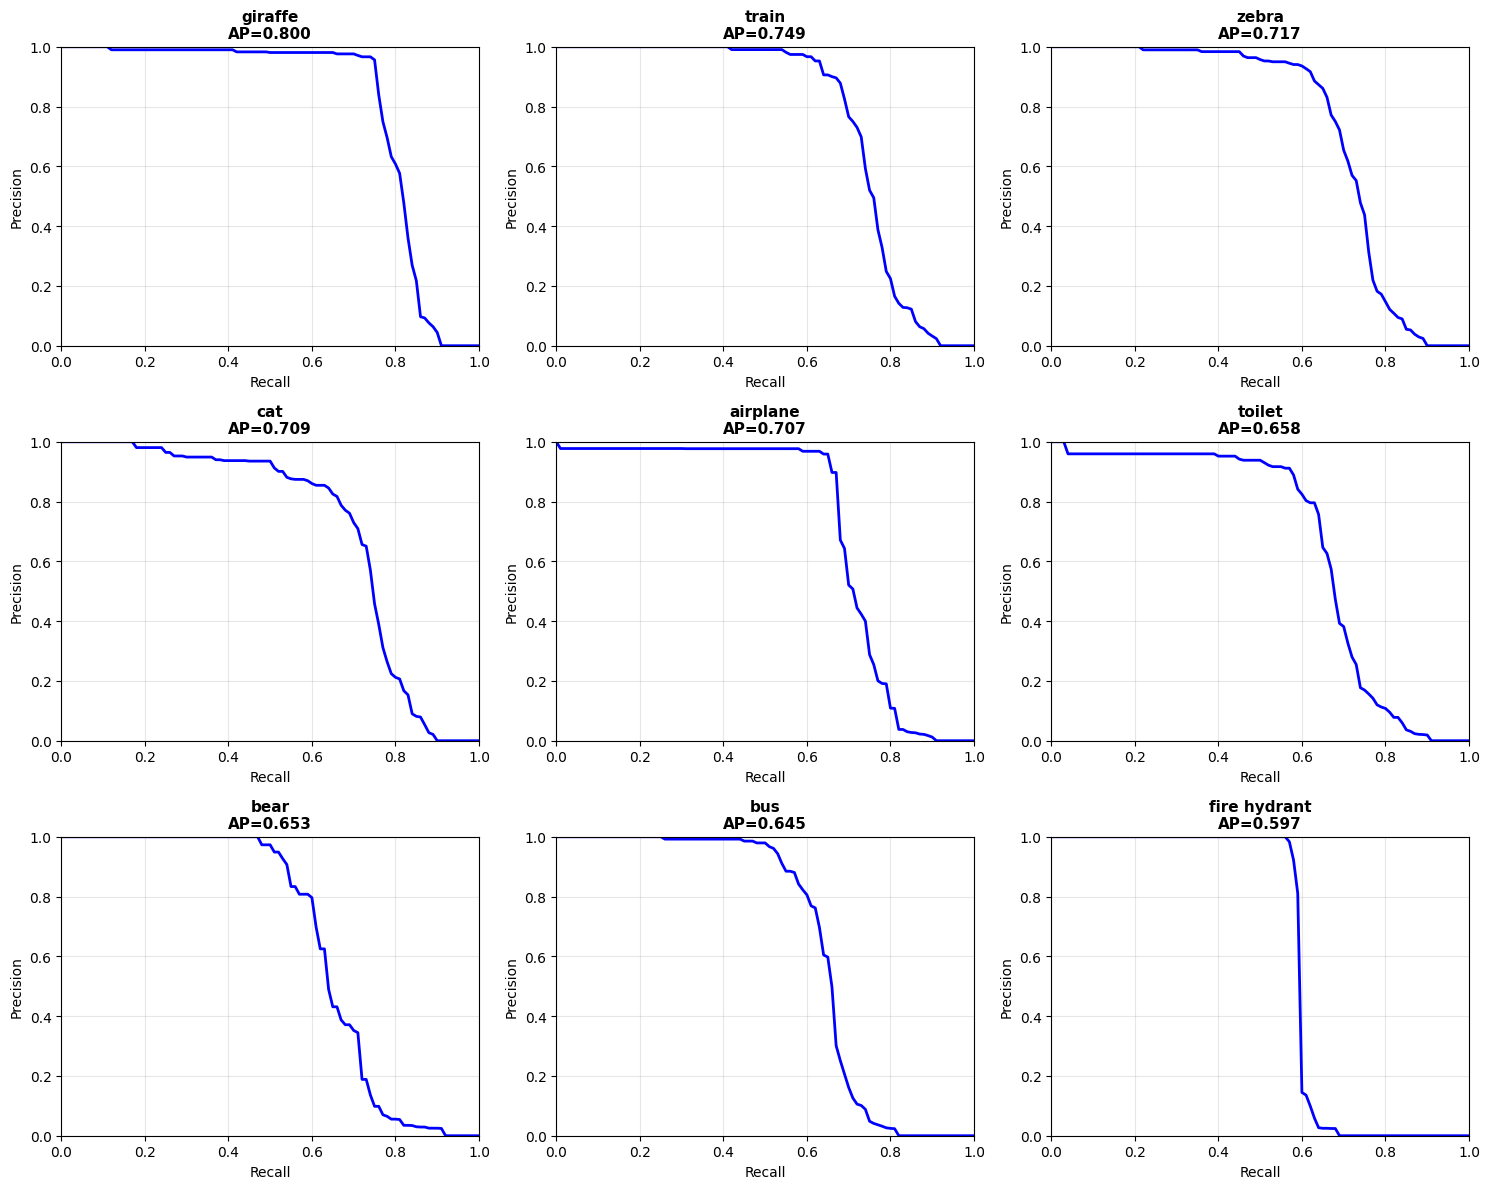


PR curves saved to 'pr_curves_top9.png'


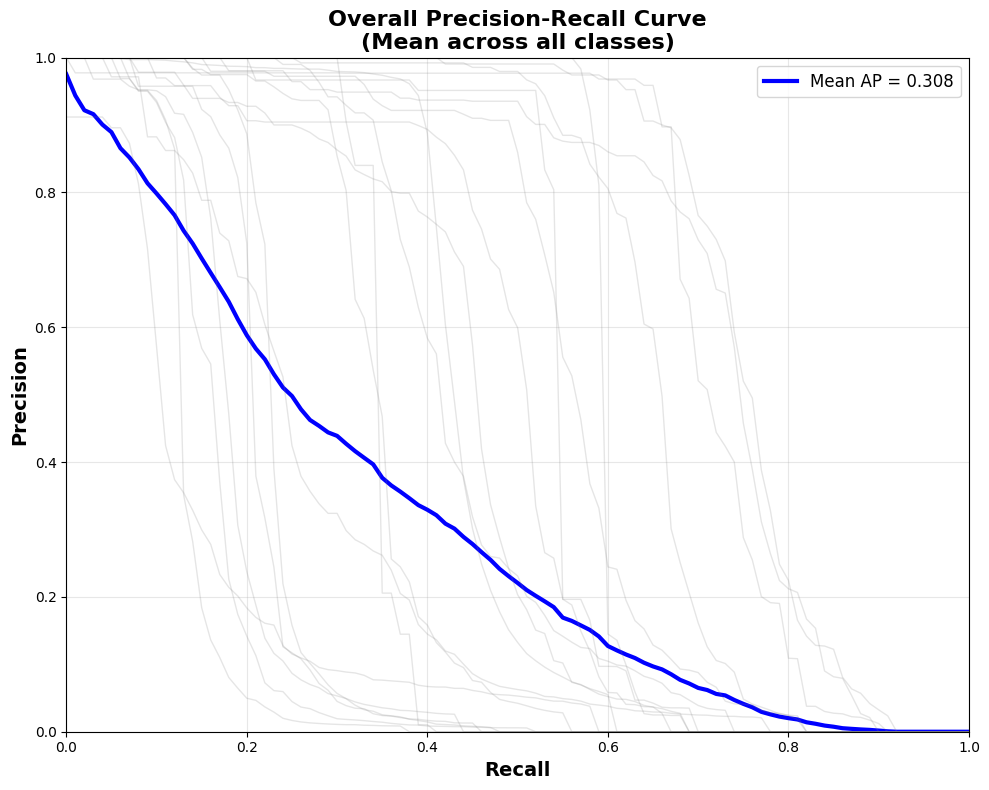


Overall PR curve saved to 'pr_curve_overall.png'


In [9]:
# Cell 11: Plot PR curves for top classes
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

# Sort classes by AP
sorted_classes = sorted(pr_curves.items(), key=lambda x: x[1]['ap'], reverse=True)

print("\nTop 9 classes by AP:")
for idx, (cat_id, pr_data) in enumerate(sorted_classes[:9]):
    cat_name = coco_gt.loadCats(cat_id)[0]['name']
    ap = pr_data['ap']
    
    print(f"{idx+1}. {cat_name}: AP = {ap:.4f}")
    
    axes[idx].plot(pr_data['recall'], pr_data['precision'], 'b-', linewidth=2)
    axes[idx].set_xlabel('Recall', fontsize=10)
    axes[idx].set_ylabel('Precision', fontsize=10)
    axes[idx].set_title(f'{cat_name}\nAP={ap:.3f}', fontsize=11, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_xlim([0, 1])
    axes[idx].set_ylim([0, 1])

plt.tight_layout()
plt.savefig('pr_curves_top9.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nPR curves saved to 'pr_curves_top9.png'")
all_precisions = []
all_recalls = []

for cat_id, pr_data in pr_curves.items():
    all_precisions.append(pr_data['precision'])
    all_recalls.append(pr_data['recall'])

# Interpolate to common recall points
recall_levels = np.linspace(0, 1, 101)
interpolated_precisions = []

for precision, recall in zip(all_precisions, all_recalls):
    interp_precision = np.interp(recall_levels, recall, precision, left=0, right=0)
    interpolated_precisions.append(interp_precision)

mean_precision = np.mean(interpolated_precisions, axis=0)
overall_ap = np.mean(mean_precision)

plt.figure(figsize=(10, 8))
plt.plot(recall_levels, mean_precision, 'b-', linewidth=3, label=f'Mean AP = {overall_ap:.3f}')

# Plot individual class curves in background
for precision, recall in zip(all_precisions[:20], all_recalls[:20]):  # Plot first 20 for clarity
    plt.plot(recall, precision, 'gray', alpha=0.2, linewidth=1)

plt.xlabel('Recall', fontsize=14, fontweight='bold')
plt.ylabel('Precision', fontsize=14, fontweight='bold')
plt.title('Overall Precision-Recall Curve\n(Mean across all classes)', fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(fontsize=12, loc='upper right')
plt.tight_layout()
plt.savefig('pr_curve_overall.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nOverall PR curve saved to 'pr_curve_overall.png'")

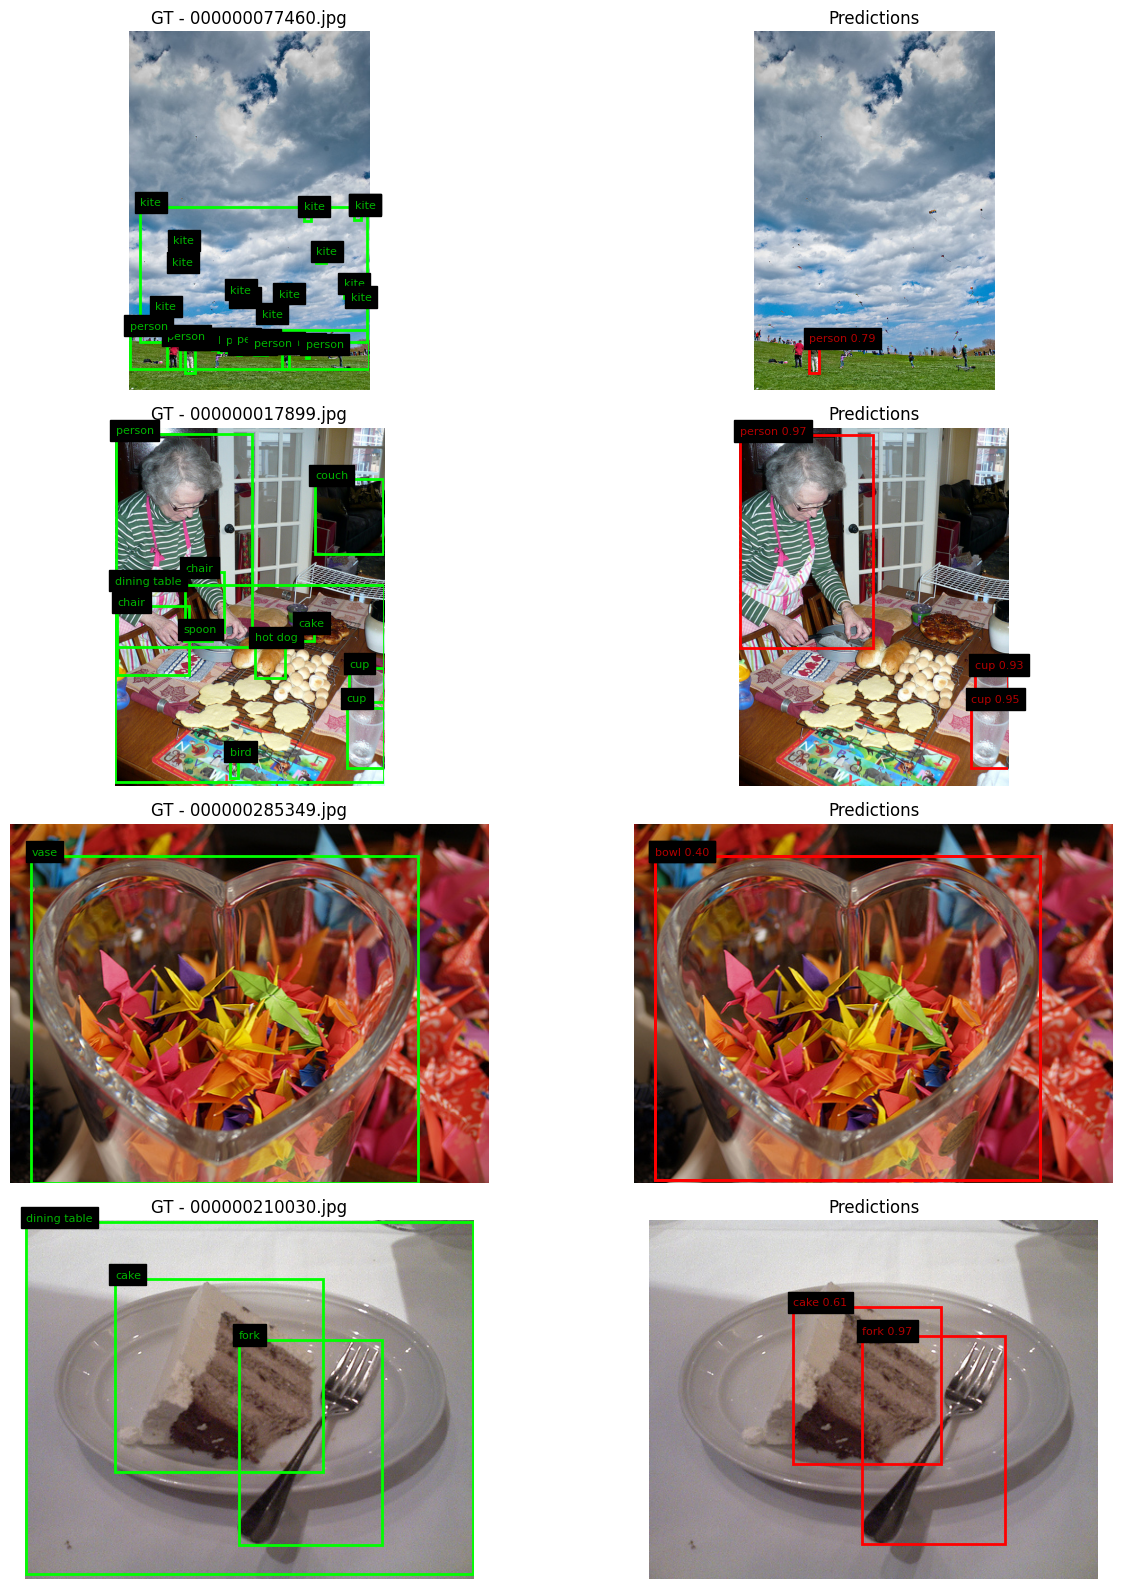

In [10]:
from matplotlib.patches import Rectangle
import random

sample_image_ids = random.sample(image_ids, min(5, len(image_ids)))

# Visualize some predictions
# pick 4 image ids to visualize
img_ids_to_show = sample_image_ids[:4] if isinstance(sample_image_ids, list) and len(sample_image_ids) >= 4 else image_ids[:4]

# Create subplots (handle single-row case)
fig, axes = plt.subplots(len(img_ids_to_show), 2, figsize=(14, 4 * len(img_ids_to_show)))
if len(img_ids_to_show) == 1:
    axes = np.expand_dims(axes, 0)  # make it 2D for consistent indexing
axes = axes.reshape(-1, 2)

for row_idx, img_id in enumerate(img_ids_to_show):
    # load image info and file
    img_info = coco_gt.loadImgs(img_id)[0]
    img_path = os.path.join(val_images_dir, img_info['file_name'])
    if not os.path.exists(img_path):
        print(f"Missing image: {img_path}, skipping")
        continue
    image = Image.open(img_path).convert("RGB")
    
    # Ground truth (left)
    ax_gt = axes[row_idx, 0]
    ax_gt.imshow(image)
    ax_gt.set_title(f"GT - {img_info['file_name']}")
    ax_gt.axis("off")
    
    ann_ids = coco_gt.getAnnIds(imgIds=[img_id])
    anns = coco_gt.loadAnns(ann_ids)
    for ann in anns:
        x, y, w, h = ann['bbox']
        cat_name = coco_gt.loadCats(ann['category_id'])[0]['name']
        rect = Rectangle((x, y), w, h, linewidth=2, edgecolor='lime', facecolor='none')
        ax_gt.add_patch(rect)
        ax_gt.text(x, y - 2, cat_name, color='lime', fontsize=8, backgroundcolor='black', alpha=0.7)
    
    # Predictions (right)
    ax_pred = axes[row_idx, 1]
    ax_pred.imshow(image)
    ax_pred.set_title("Predictions")
    ax_pred.axis("off")
    
    results_pred, _ = run_inference(img_path, model, processor, device, threshold=0.1)
    boxes = results_pred['boxes'].cpu().numpy()
    scores = results_pred['scores'].cpu().numpy()
    labels = results_pred['labels'].cpu().numpy()
    
    # draw predictions (filter by score and limit number for clarity)
    keep_idx = np.where(scores >= 0.3)[0]
    for idx in keep_idx[:50]:
        x_min, y_min, x_max, y_max = boxes[idx]
        w, h = x_max - x_min, y_max - y_min
        label = class_names[labels[idx]] if labels[idx] < len(class_names) else str(int(labels[idx]))
        score = scores[idx]
        rect = Rectangle((x_min, y_min), w, h, linewidth=2, edgecolor='red', facecolor='none')
        ax_pred.add_patch(rect)
        ax_pred.text(x_min, y_min - 2, f"{label} {score:.2f}", color='red', fontsize=8, backgroundcolor='black', alpha=0.7)

plt.tight_layout()
plt.show()